# Money Management: Stock Price Forecasting Using Neural Sequence Translation

Neural Sequence Translation (NST) is an tweak version of Recurrent Neural Network which not just forecasts a point in the future but an entire vector in the future. Just like [Neural Machine Translation](https://arxiv.org/abs/1409.0473), this notebook explores this upgrade philosophy and apply this idea in a singular stock data.

Stock price today is probably dependent on:
- The trend it has been folloing from the previous day.
- The price it was traded at from previous day.
- Some other factors that may affect stock price today.

Generalize intuition from above to the following:
- The previous cell state (i.e. the information that was present in the memory after the previous time step).
- The previous hidden state (i.e. this is the same as the output of the previous cell).
- The input at the current time step (i.e. the new information that is being fed in at that moment).

In this notebook, we cover
- Part 1 - Data Preprocessing
- Part 2 - Construct NST Architecture
- Part 3 - Predictions and Performance Visualization

A Production of [Yin's Capital](www.YinsCapital.com)

## Recurrent Neural Network (a sequential model)

Given data $X$ and $Y$, we want to feed information forward into a time stamp. Then we form some belief and we make some initial predictions. We investigate our beliefs by looking at the loss function of the initial guesses and the real value. We update our model according to error we observed. 

## Architecture: Feed-forward

Consider data with time stamp
$$X_{\langle 1 \rangle} \rightarrow X_{\langle 2 \rangle} \rightarrow \dots \rightarrow X_{\langle T \rangle}$$
and feed-forward architecture pass information through exactly as the following:
$$
\text{Information in:} \rightarrow
\begin{matrix}
\{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} &       & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} \\
\updownarrow               & \updownarrow               &       & \updownarrow \\
\{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} &       & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \rightarrow    & X_{\langle 2 \rangle} \rightarrow    & \dots \rightarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w_{\langle 1 \rangle}, b_{0, \langle 1 \rangle}    & w_{\langle 2 \rangle}, b_{0, \langle 2 \rangle}    &       & w_{\langle T \rangle}, b_{0, \langle T \rangle} \\
\end{matrix}
\rightarrow
\text{Form beliefs about } Y_{\langle T \rangle}
$$
while the educated guesses $\hat{Y}_{\langle T \rangle}$ are our beliefs about real $Y$ at time stamp $T$. 

## Architecture: Feed-backward

Let us clearly define our loss function to make sure we have a proper grip of our mistakes. 
$$\mathcal{L} = \sum_t \sum_k L(\hat{y}_{\langle t,k \rangle} - y_{\langle t,k \rangle})^2$$
and we can compute the gradient 
$$\triangledown = \frac{\partial \mathcal{L}}{\partial a}$$
and then with respect with parameters $w$ and $b$
$$\frac{\partial \triangledown}{\partial w}, \frac{\partial \triangledown}{\partial a}$$
and now with perspective of where we make our mistakes according to our parameters we can go backward
$$
\text{Information in:} \leftarrow
\underbrace{
\begin{matrix}
\{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} &       & \{Y_{\langle 1 \rangle}, ..., Y_{\langle k \rangle}\} \\
\updownarrow               & \updownarrow               &       & \updownarrow \\
\{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} &       & \{\hat{Y}_{\langle 1 \rangle}, ..., \hat{Y}_{\langle k \rangle}\} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \leftarrow    & X_{\langle 2 \rangle} \leftarrow    & \dots \leftarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w'_{\langle 1 \rangle}, b'_{0, \langle 1 \rangle}    & w'_{\langle 2 \rangle}, b'_{0, \langle 2 \rangle}    &       & w'_{\langle T \rangle}, b'_{0, \langle T \rangle} \\
\end{matrix}}_{\text{Update: } w, b \text{ with } w', b'}
\leftarrow
\text{Total Loss: } \mathcal{L} (\hat{y}, y)
$$
and the *update* action in the above architecture is dependent on your optimizer specified in the algorithm.

## Part 1: Data Processing

In [1]:
# libraries
import pandas as pd
import numpy as np

In [2]:
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3 MB 6.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
# set parameters
start_date       =   '2013-01-01'
end_date         =   '2021-09-04'
ticker           =   'AAPL'
w                =   3
h                =   5
max_len          =   1000 # use this if Embedding is used
output_dim       =   5 # use this if Embedding is used
cutoff           =   0.9
numOfHiddenLayer =   4
numOfDense       =   3
l1_units         =   128*4
l2_units         =   128*3
l2_units         =   128*2
l3_units         =   128
l4_units         =   30
l5_units         =   10
dropOutRate       =  0.3
optimizer        =   'adam'
loss             =   'mean_squared_error'
useDice          =   True
epochs           =   100
batch_size       =   64
plotGraph        =   True
verbose          =   True

In [4]:
# get data
stockData = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


We make the following simple assumptions:
- the explanatory data matrix $X$ is the downloaded stock data except the first row
- the response data matrix $Y$ is the downloaded stock data except the last row
- this way we are using stock data at $t$ to predict stock data at $t+1$
- the information in the response data matrix $Y$: open, high, low, close, adjusted close

In [5]:
stockData = stockData.iloc[:,:5]

In [6]:
stockData.head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.960691
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.746613


In [7]:
stockData.iloc[w::,].head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.184376
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.227934


In [8]:
stockData.iloc[w::,].shape

(2182, 5)

In [9]:
stockData.iloc[0:int(stockData.shape[0]-w),].head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.960691
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.746613


In [10]:
stockData.iloc[0:int(stockData.shape[0]-w),].shape

(2182, 5)

In [11]:
Y = stockData.iloc[w::, ]
# X = stockData.iloc[0:int(stockData.shape[0]-w),]

X = np.arange(0, Y.shape[0]*w*h, 1).reshape(Y.shape[0], w*h)
for i in range(0,int(stockData.shape[0]-w)):
    X[i,] = np.array(stockData.iloc[i:(i+w),]).reshape(1, w*h)

In [12]:
print(X.shape)
print(Y.shape)

(2182, 15)
(2182, 5)


In [13]:
X_train = X[0:round(X.shape[0]*cutoff), ]
X_test = X[round(X.shape[0]*cutoff):X.shape[0], ]

In [14]:
y_train = Y.iloc[0:round(Y.shape[0]*cutoff), ]
y_test = Y.iloc[round(Y.shape[0]*cutoff):Y.shape[0], ]

In [15]:
X_train = np.array(X_train).reshape(X_train.shape[0], w*h) # dim would be 1, w*h if Embedding is used
X_test = np.array(X_test).reshape(X_test.shape[0], w*h)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1964, 15)
(218, 15)
(1964, 5)
(218, 5)


## Part 2: Design a Neural Sequence Translation Architecture

In [17]:
### Build RNN
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LayerNormalization
import time

In [18]:
# Initialize RNN
begintime = time.time()
regressor = Sequential()

In [19]:
# Embedding
regressor.add(Embedding(input_dim=max_len, output_dim=output_dim, input_length=w*h))

In [20]:
# Comment
# regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w*h, output_dim))) # this is if Embedding is used
# regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w, h))) # this is if no Embedding is used

# Design hidden layers
if numOfHiddenLayer == 2:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w*h, output_dim)))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units))
    regressor.add(Dropout(dropOutRate))

elif numOfHiddenLayer == 3:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w*h, output_dim)))
    regressor.add(LayerNormalization(axis=1))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units, return_sequences = True))
    regressor.add(LayerNormalization(axis=1))
    regressor.add(Dropout(dropOutRate))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l3_units))
    regressor.add(Dropout(dropOutRate))

elif numOfHiddenLayer == 4:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w*h, output_dim)))
    regressor.add(LayerNormalization(axis=1))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units, return_sequences = True))
    regressor.add(LayerNormalization(axis=1))
    regressor.add(Dropout(dropOutRate))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l3_units, return_sequences = True))
    regressor.add(LayerNormalization(axis=1))
    regressor.add(Dropout(dropOutRate))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l4_units))
    regressor.add(LayerNormalization(axis=1))
    regressor.add(Dropout(dropOutRate))

elif numOfHiddenLayer == 5:
    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l1_units, return_sequences = True, input_shape = (w*h, output_dim)))
    regressor.add(Dropout(dropOutRate))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l2_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l3_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l4_units, return_sequences = True))
    regressor.add(Dropout(dropOutRate))

    # Adding a fifth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = l5_units))
    regressor.add(Dropout(dropOutRate))

In [21]:
if numOfDense == 1:
    regressor.add(Dense(units = l1_units))
elif numOfDense == 2:
    regressor.add(Dense(units = l1_units))
    regressor.add(Dense(units = l2_units))
elif numOfDense == 3:
    regressor.add(Dense(units = l1_units))
    regressor.add(Dense(units = l2_units))
    regressor.add(Dense(units = l3_units))
else:
    if verbose:
        print("Options are 1, 2, or 3. Reset to one dense layer.")
    regressor.add(Dense(units = l1_units))

In [22]:
# Adding the output layer
regressor.add(Dense(units = y_train.shape[1]))
endtime = time.time()

In [23]:
# Summary
if verbose:
    print("--------------------------------------------")
    print('Let us investigate the sequential models.')
    regressor.summary()
    print("--------------------------------------------")
    print("Time Consumption (in sec):", endtime - begintime)
    print("Time Consumption (in min):", round((endtime - begintime)/60, 2))
    print("Time Consumption (in hr):", round((endtime - begintime)/60)/60, 2)
    print("--------------------------------------------")

--------------------------------------------
Let us investigate the sequential models.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 5)             5000      
                                                                 
 lstm (LSTM)                 (None, 15, 512)           1060864   
                                                                 
 layer_normalization (LayerN  (None, 15, 512)          30        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 15, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 15, 256)           787456    
                                                                 
 layer_normalization_1 (Laye  (None

In [24]:
### Train RNN
# Compiling the RNN
start = time.time()
regressor.compile(optimizer = optimizer, loss = loss)

In [25]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
end = time.time()

Epoch 1/100
31/31 [==============================] - 29s 584ms/step - loss: 806.8318
Epoch 2/100
31/31 [==============================] - 19s 614ms/step - loss: 531.2992
Epoch 3/100
31/31 [==============================] - 18s 590ms/step - loss: 528.6227
Epoch 4/100
31/31 [==============================] - 18s 594ms/step - loss: 442.0924
Epoch 5/100
31/31 [==============================] - 19s 598ms/step - loss: 212.8844
Epoch 6/100
31/31 [==============================] - 19s 598ms/step - loss: 123.7754
Epoch 7/100
31/31 [==============================] - 18s 591ms/step - loss: 81.8445
Epoch 8/100
31/31 [==============================] - 16s 508ms/step - loss: 56.7234
Epoch 9/100
31/31 [==============================] - 16s 508ms/step - loss: 52.8344
Epoch 10/100
31/31 [==============================] - 15s 468ms/step - loss: 43.7835
Epoch 11/100
31/31 [==============================] - 14s 460ms/step - loss: 34.0430
Epoch 12/100
31/31 [==============================] - 14s 464ms/step

In [26]:
# Time Check
if verbose == True: 
    print('Time Consumption:', end - start)

Time Consumption: 1420.2326221466064


## Part 3: Predictions and Performance Visualization

In [27]:
### Predictions
predicted_stock_price = regressor.predict(X_test)

In [28]:
real_stock_price = y_test

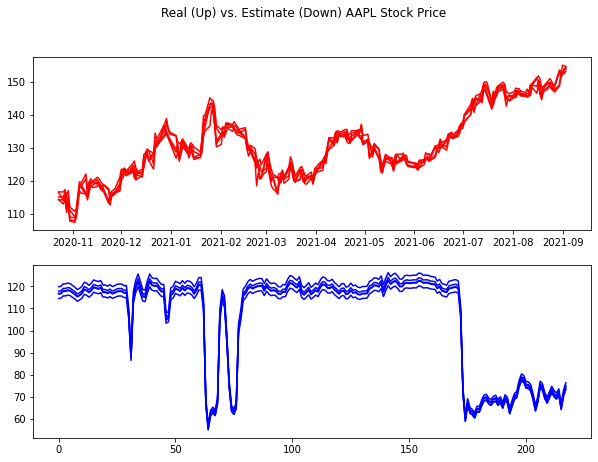

In [29]:
# Visualising the results
import matplotlib.pyplot as plt
if plotGraph:
    fig, axs = plt.subplots(2, figsize = (10,7))
    fig.suptitle(f'Real (Up) vs. Estimate (Down) {ticker} Stock Price')
    axs[0].plot(real_stock_price, color = 'red', label = f'Real {ticker} Stock Price')
    axs[1].plot(predicted_stock_price, color = 'blue', label = f'Predicted {ticker} Stock Price')

In [30]:
!pip install mplfinance
import mplfinance as mpf

     |████████████████████████████████| 62 kB 929 kB/s 


In [31]:
mpf.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

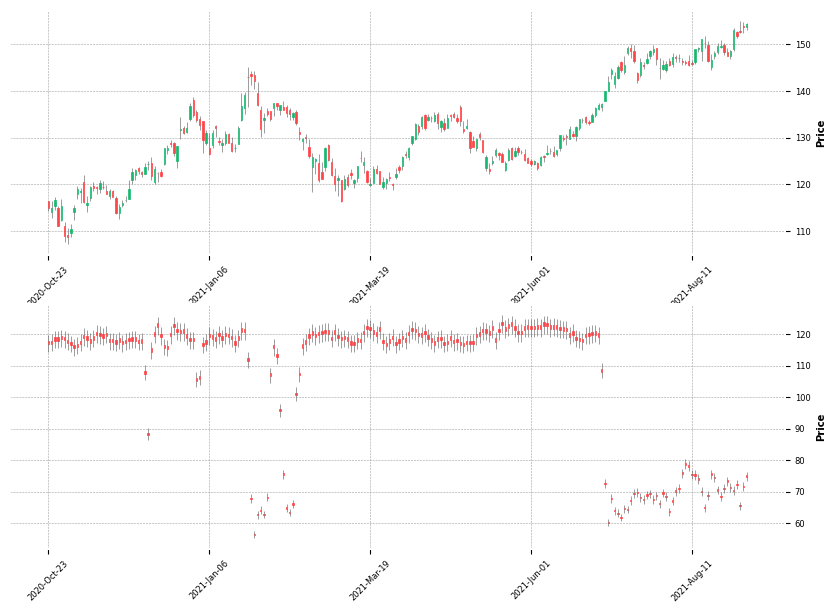

In [32]:
predicted_stock_price = pd.DataFrame(predicted_stock_price)
predicted_stock_price.columns = real_stock_price.columns
predicted_stock_price.index = real_stock_price.index

s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})
fig = mpf.figure(figsize=(10, 7), style=s) # pass in the self defined style to the whole canvas
ax = fig.add_subplot(2,1,1) # main candle stick chart subplot, you can also pass in the self defined style here only for this subplot
av = fig.add_subplot(2,1,2, sharex=ax)  # volume chart subplot

df1 = real_stock_price
mpf.plot(df1, type='candle', style='yahoo', ax=ax, volume=False)

df2 = predicted_stock_price
mpf.plot(df2, type='candle', style='yahoo', ax=av)

## Part 4: Software Development

In [33]:
!pip install git+https://github.com/yiqiao-yin/YinPortfolioManagement.git

  Cloning https://github.com/yiqiao-yin/YinPortfolioManagement.git to /tmp/pip-req-build-88l1rtok
  Running command git clone -q https://github.com/yiqiao-yin/YinPortfolioManagement.git /tmp/pip-req-build-88l1rtok
  Created wheel for YinPortfolioManagement: filename=YinPortfolioManagement-1.0.0-py3-none-any.whl size=10112 sha256=7004b2d39ef687561eada2cff58601b678d5cab1fd224bc4dc57d71048d4cb3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-p534fbq7/wheels/50/84/70/255b8f80fcb1e2c4503fbaf167a96ac216456ee314a224a998
Successfully built YinPortfolioManagement


In [34]:
!pip install ta

  Created wheel for ta: filename=ta-0.8.0-py3-none-any.whl size=28895 sha256=4e567e3ae898d808718038c5c7389f1991c418294b8ffe83570ee62226bc6e2d
  Stored in directory: /root/.cache/pip/wheels/7e/da/86/65cba22446ae2ef148de2079907264ef27feecfb7f51a45e0d
Successfully built ta


In [35]:
from YinCapital_forecast.modules import Neural_Sequence_Translation

------------------------------------------------------------------------------

            MANUAL: To install this python package, please use the following code.

            # In a python notebook:
            # !pip install git+https://github.com/yiqiao-yin/YinPortfolioManagement.git
            # In a command line:
            # pip install git+https://github.com/yiqiao-yin/YinPortfolioManagement.git

            # Run
            tmp = Neural_Sequence_Translation(
                start_date       =   '2013-01-01',
                end_date         =   '2021-01-01',
                ticker           =   'AAPL',
                w                =   1,
                h                =   5,
                cutoff           =   0.8,
                numOfHiddenLayer =   3,
                numOfDense       =   2,
                l1_units         =   50,
                l2_units         =   50,
                l2_units         =   50,
                l3_units         =   50,
             

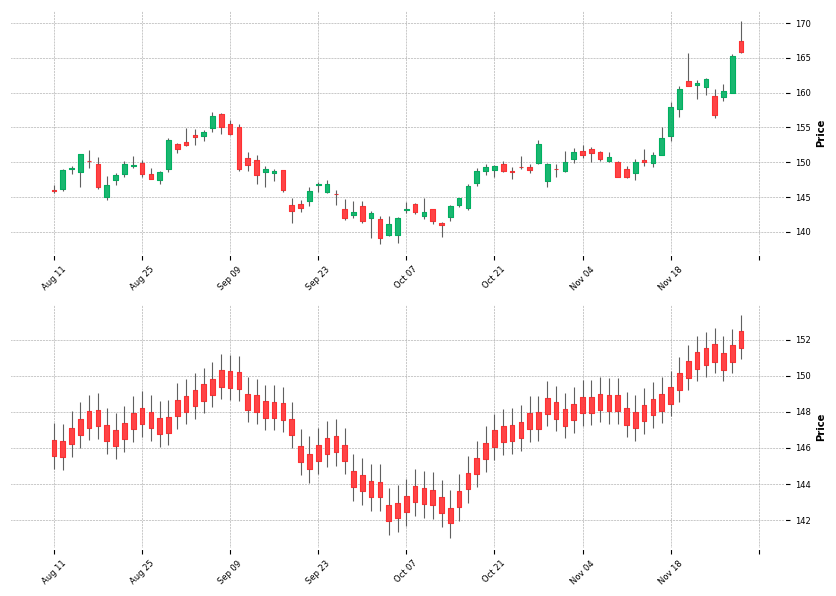

In [40]:
tmp = Neural_Sequence_Translation(
        start_date       =   '2014-01-01',
        end_date         =   '2021-12-30',
        ticker           =   'AAPL',
        w                =   10 ,
        h                =   5,
        cutoff           =   0.96,
        numOfHiddenLayer =   2,
        numOfDense       =   3,
        l1_units         =   128*4,
        l2_units         =   128*3,
        l3_units         =   128,
        l4_units         =   30,
        l5_units         =   10,
        dropOutRate       =  0.3,
        optimizer        =   'adam',
        loss             =   'mean_squared_error',
        epochs           =   120,
        batch_size       =   64,
        plotGraph        =   False,
        verbose          =   True )

Ends here.